In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('../raw_data.csv')
df.head()

,startCarNumber,totalCarNumber,overhead,duration
0,446,450,2.580427,211
1,445,450,1.420214,436
2,446,450,1.785948,477
3,446,450,2.273079,370
4,446,450,1.688872,203


In [3]:
df.describe()

,startCarNumber,totalCarNumber,overhead,duration
count,187387.000000,187387.000000,187387.000000,1.873870e+05
mean,458.802398,472.240924,2.563810,7.752297e+02
std,144.259421,152.090439,3.809806,1.531089e+04
min,46.000000,50.000000,0.724788,2.000000e+00
25%,349.000000,350.000000,1.363578,1.780000e+02
50%,497.000000,500.000000,1.744196,3.030000e+02
75%,546.000000,550.000000,2.259356,4.670000e+02
max,718.000000,720.000000,30.000000,1.025544e+06


In [4]:
df_before = df.iloc[:108154, :].reset_index()
df_after = df.iloc[108154: , :].reset_index()

In [5]:
df_before.describe()

,index,startCarNumber,totalCarNumber,overhead,duration
count,108154.000000,108154.000000,108154.000000,108154.000000,108154.00000
mean,54076.500000,453.939891,459.281857,1.910380,449.96873
std,31221.514844,142.445530,144.986841,1.152956,5659.11262
min,0.000000,46.000000,50.000000,0.826582,2.00000
25%,27038.250000,349.000000,350.000000,1.358461,176.00000
50%,54076.500000,497.000000,500.000000,1.716021,298.50000
75%,81114.750000,546.000000,550.000000,2.155866,449.00000
max,108153.000000,619.000000,620.000000,30.000000,330835.00000


In [6]:
df_after.describe()

,index,startCarNumber,totalCarNumber,overhead,duration
count,79233.000000,79233.000000,79233.000000,79233.000000,7.923300e+04
mean,147770.000000,465.439779,489.930206,3.455749,1.219215e+03
std,22872.741276,146.439721,159.594043,5.579838,2.259117e+04
min,108154.000000,46.000000,50.000000,0.724788,2.000000e+00
25%,127962.000000,349.000000,350.000000,1.370538,1.800000e+02
50%,147770.000000,495.000000,500.000000,1.792687,3.100000e+02
75%,167578.000000,591.000000,600.000000,2.455580,4.990000e+02
max,187386.000000,718.000000,720.000000,30.000000,1.025544e+06


In [7]:
df_before = df
df_before['c'] = df_before['totalCarNumber'].diff()
df_filtered = df_before[df_before['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
print(len(index_list))
print('\n')
print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df_before.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

len(list_of_dfs)

47


[0, 8294, 17403, 27254, 34651, 38974, 39532, 42659, 43188, 45981, 54942, 64656, 74558, 83583, 89885, 92939, 102197, 111085, 121194, 131338, 137335, 140948, 141937, 151112, 153660, 156612, 159425, 161427, 162463, 162656, 163537, 163671, 164404, 166791, 169393, 171298, 173484, 174769, 175455, 177865, 180027, 181560, 181570, 183517, 184418, 184630, 187080]


47

In [8]:
one = list_of_dfs[1]

In [9]:
one['duration']

8294     374
8295     374
8296     144
8297     410
8298     192
        ... 
17398    437
17399    425
17400    349
17401    507
17402    423
Name: duration, Length: 9109, dtype: int64

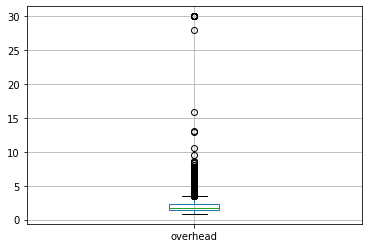

In [10]:
boxplot = one.boxplot(column=['overhead'])

In [11]:
one.describe()

,startCarNumber,totalCarNumber,overhead,duration,c
count,9109.000000,9109.0,9109.000000,9109.000000,9109.000000
mean,515.186958,520.0,1.982531,381.368646,0.007685
std,7.644197,0.0,1.337981,1108.651257,0.733437
min,443.000000,520.0,0.840509,2.000000,0.000000
25%,515.000000,520.0,1.393429,186.000000,0.000000
50%,516.000000,520.0,1.773234,312.000000,0.000000
75%,517.000000,520.0,2.243396,471.000000,0.000000
max,519.000000,520.0,30.000000,30812.000000,70.000000


In [12]:
duration_df = pd.DataFrame()
counter = 0
for i in list_of_dfs:
    duration_df = pd.concat([duration_df,i['duration'].reset_index()['duration']], ignore_index=True, axis=1)
    counter += 1

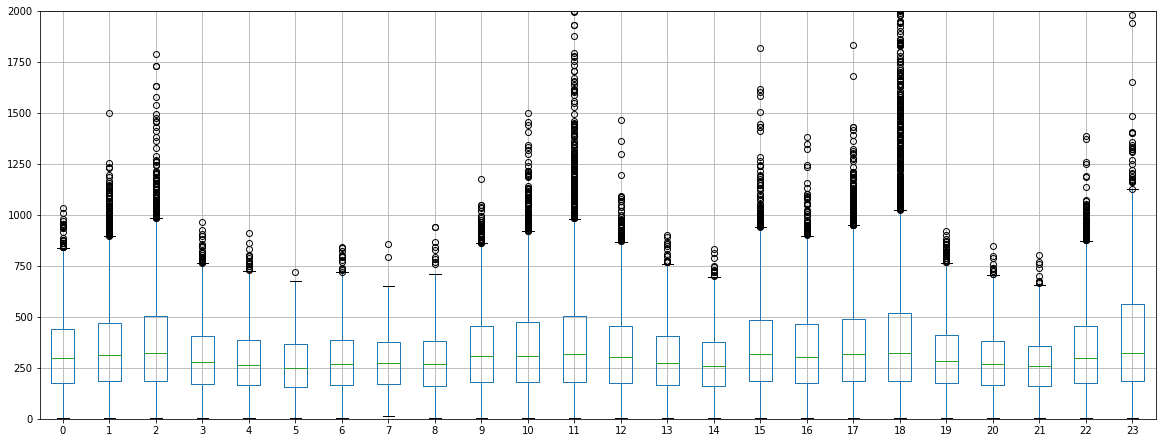

In [13]:
columns = list(range(0, 24))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = duration_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,2000])
plt.show()

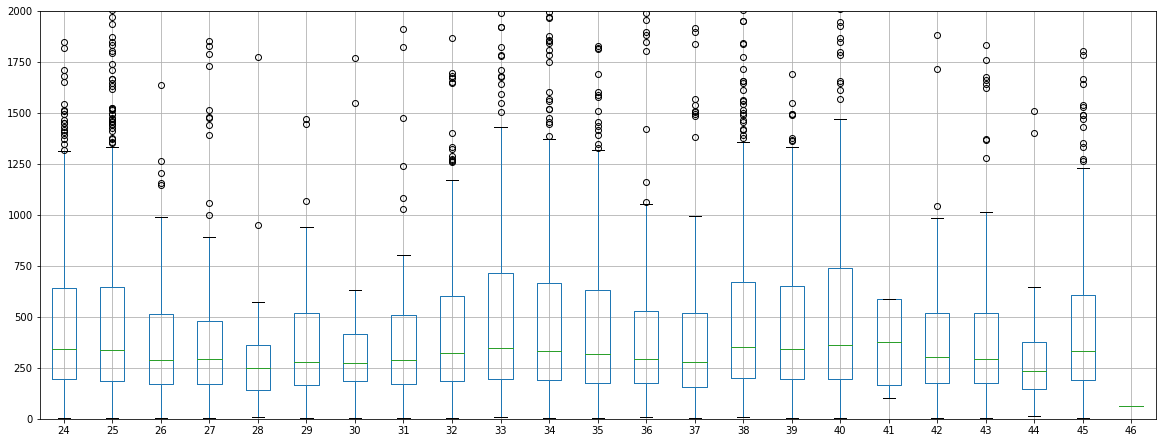

In [14]:
columns = list(range(24, 47))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = duration_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,2000])
plt.show()

In [15]:
overhead_df = pd.DataFrame()
counter = 0
for i in list_of_dfs:
    overhead_df = pd.concat([overhead_df,i['overhead'].reset_index()['overhead']], ignore_index=True, axis=1)
    counter += 1

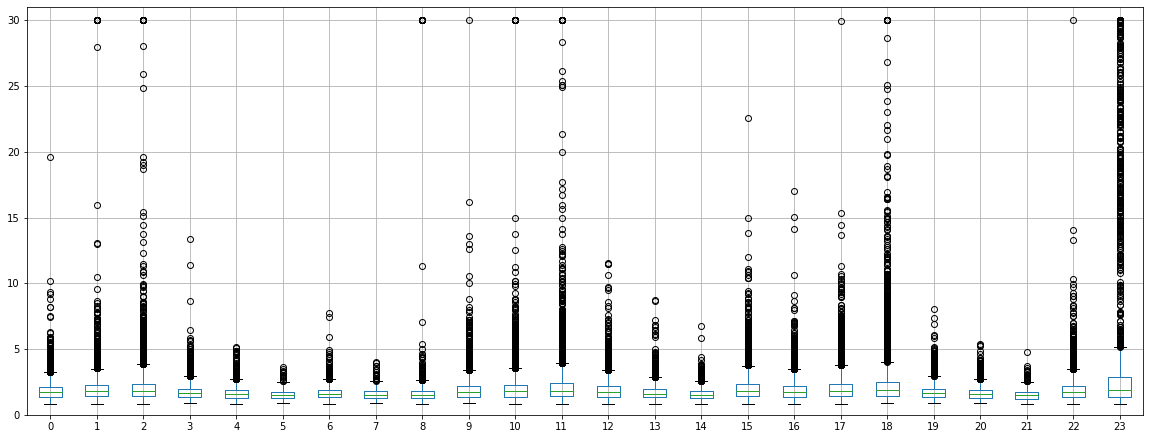

In [16]:
columns = list(range(0, 24))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = overhead_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,31])
plt.show()

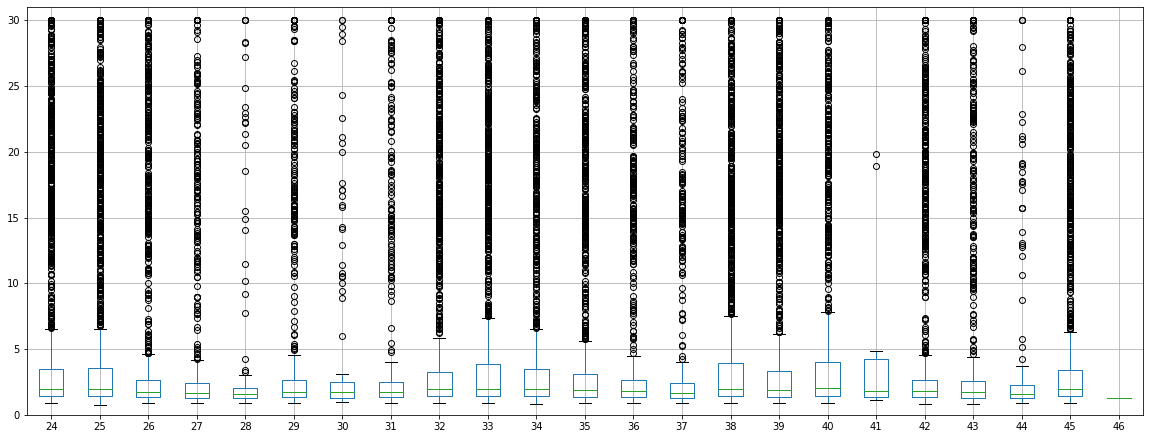

In [17]:
columns = list(range(24, 47))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = overhead_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,31])
plt.show()

In [18]:
df_data = pd.read_csv('../data.csv')
df_data.head()

,index,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead
0,0,450,1022,1.692192,1.373016,2.107207,2.475518
1,1,450,1452,1.701939,1.345283,2.129731,2.621037
2,2,450,1453,1.734229,1.376936,2.161141,2.649318
3,3,450,1469,1.687678,1.350706,2.079449,2.575552
4,4,450,1438,1.721359,1.377186,2.119356,2.617978


In [19]:
df_data = df_data.iloc[::6, :].reset_index()
df_data = df_data.drop(columns=['index', 'level_0'])
df_data.head(10)

# ax = df_data.plot.bar( y='numberOfTrips', rot=90, figsize=(20,7.5))

,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead
0,450,1022,1.692192,1.373016,2.107207,2.475518
1,520,1511,1.761871,1.379444,2.186336,2.980143
2,600,1647,1.851766,1.388860,2.435578,3.145605
3,350,1286,1.612598,1.330533,1.956720,2.400225
4,200,708,1.573297,1.316875,1.884821,2.255361
5,50,101,1.489224,1.284639,1.855171,2.152655
6,200,525,1.570875,1.311693,1.824701,2.170486
7,50,89,1.554178,1.262781,1.861647,2.319169
8,150,460,1.515552,1.321387,1.781317,2.112391
9,500,1522,1.763367,1.372734,2.218540,2.842654


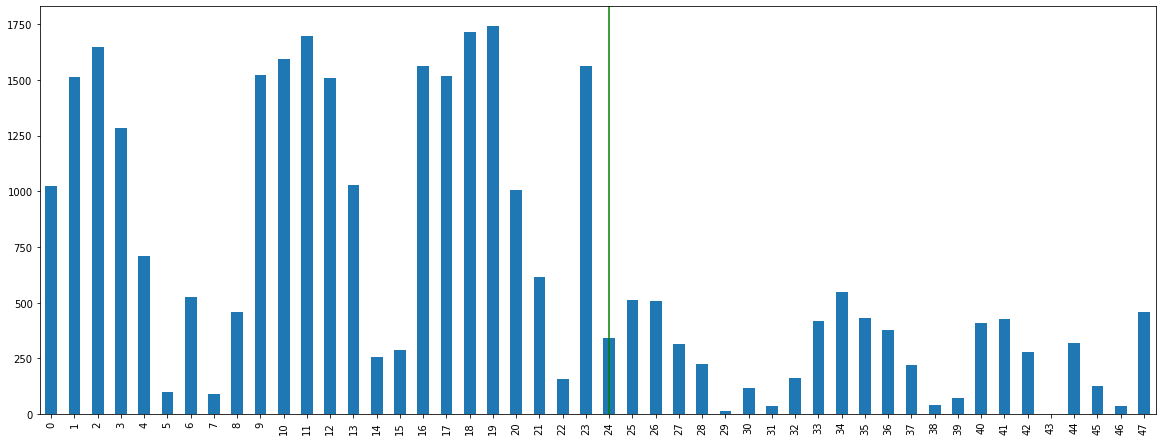

In [20]:
fig, ax = plt.subplots(figsize=(20,7.5))
ax = df_data.plot.bar(y='numberOfTrips', rot=90, ax=ax, legend=None)
ax.axvline(x=24, c='g')